<a href="https://colab.research.google.com/github/ssook1222/1Day-1Algo/blob/master/model/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

### 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 의료기관 데이터

In [3]:
csv_path_medical = '/content/drive/MyDrive/town_cc_big_data/data/행정동_강원도_춘천시_의료기관약국_20220805.csv'

In [4]:
df_medical_raw = pd.read_csv(csv_path_medical)
address_data = df_medical_raw['행정동']
kind_data = df_medical_raw['종류']

df_medical = pd.DataFrame({'종류': kind_data, '행정동': address_data})
df_medical = df_medical.groupby('행정동').count().rename(columns={'종류': '병원 수'})
df_medical = df_medical.sort_values('병원 수', ascending=True)

#### 독거노인 수 데이터

In [5]:
csv_path_old = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_독거노인현황_20220620.csv'

In [6]:
df_old_raw = pd.read_csv(csv_path_old, encoding='euc-kr')
df_old = df_old_raw.groupby('행정동명')['인구수'].sum().reset_index()
df_old = df_old.sort_values('인구수', ascending = False)

#### 정신건강 관련 기관 및 병원 데이터

In [7]:
csv_path_mental1 = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_정신건강센터 현황_20220822.csv'
csv_path_mental2 = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_정신건강의학과 현황_20220822.csv'

In [8]:
df_old_mental1 = pd.read_csv(csv_path_mental1)
df_old_mental2 = pd.read_csv(csv_path_mental2)

df_old_mental1 = df_old_mental1[['기관명', '행정동']]
df_old_mental2 = df_old_mental2[['상호명', '행정동']]

df_mental = pd.concat([df_old_mental1, df_old_mental2.rename(columns={'상호명': '기관명'})], ignore_index=True)
df_mental = df_mental.groupby('행정동')['기관명'].count().reset_index()
df_mental = df_mental.sort_values('기관명', ascending = False)

#### 1인 가구 수

In [9]:
csv_path_one_person = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_읍면동별 1인 가구수_20220816.csv'

In [10]:
df_one_person = pd.read_csv(csv_path_one_person, encoding='euc-kr')
df_one_person = df_one_person.groupby('행정동')['1인가구수'].sum().reset_index()
df_one_person = df_one_person.sort_values('1인가구수', ascending=False)

#### 행정동별 초등학교 위치 수

In [11]:
csv_path_elm = '/content/drive/MyDrive/town_cc_big_data/data/강원도교육청_춘천시초등학교_통학구역_20220731.csv'

In [12]:
df_elm = pd.read_csv(csv_path_elm, encoding='euc-kr')
df_elm = df_elm.groupby('행정동명')['관할학교명'].count().reset_index()
df_elm.columns = ['행정동명', '초등학교 수']
df_elm = df_elm.sort_values('초등학교 수', ascending=False)

#### 아동급식카드 가맹점 수

In [13]:
csv_path_store = '/content/drive/MyDrive/town_cc_big_data/data/강원도 춘천시_아동급식카드 가맹점_20220608.csv'

In [14]:
df_store = pd.read_csv(csv_path_store, encoding='euc-kr')
df_store = df_store[['소재지지번주소', '가맹점명']]
for index, row in df_store.iterrows():
    address = row['소재지지번주소']
    split_data = address.split()
    if len(split_data) >= 3:
        new_data = split_data[2]
        df_store.at[index, '소재지지번주소'] = new_data

df_store = df_store.groupby('소재지지번주소').size().reset_index(name='가맹점수')
df_store = df_store.sort_values('가맹점수', ascending=False)
df_store = df_store.rename(columns={'가맹점수': '가맹점 수'})

### [참고] 데이터 목록
---
df_medical : 의료기관 데이터     
df_old : 독거 노인 수 데이터    
df_mental : 정신건강 관련 기관 총합 데이터        
df_one_person : 1인 가구 수 데이터    
df_elm : 행정동별 초등학교 위치 수 데이터     
df_store : 아동급식카드 가맹점 수 데이터

### 클러스터링 - 군집 예측 분석

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#### 데이터 전처리

In [29]:
df_merged = df_medical.merge(df_old, left_on='행정동', right_on='행정동명', how='left')
df_merged = df_merged.merge(df_mental, right_on='행정동', left_on='행정동명', how='left')
df_merged = df_merged.merge(df_one_person, on='행정동', how='left')
df_merged = df_merged.merge(df_elm, on='행정동명', how='left')
df_merged = df_merged.merge(df_store, left_on='행정동', right_on='소재지지번주소', how='left')

In [17]:
df_merged = df_merged[['행정동', '병원 수', '인구수', '기관명', '1인가구수', '초등학교 수', '가맹점 수']]
df_merged.columns = ['행정동', '병원 수', '인구수', '정신건강 기관 수', '1인가구 수', '초등학교 수','아동급식카드 가맹점 수']

In [18]:
df_merged.fillna(0, inplace=True)

In [19]:
df_merged.set_index('행정동', inplace=True)

In [20]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_merged), columns=df_merged.columns, index=df_merged.index)

#### 클러스터링 진행

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [22]:
df_clustered = df_merged.copy()
df_clustered['Cluster'] = kmeans.labels_

In [23]:
for cluster_num in range(3):
    cluster_df = df_clustered[df_clustered['Cluster'] == cluster_num]
    if len(cluster_df) > 0:
        print(f"Cluster {cluster_num + 1}: {', '.join(cluster_df.index.astype(str))}")
    else:
        print(f"Cluster {cluster_num + 1}: No data points in this cluster")

Cluster 1: 퇴계동, 0
Cluster 2: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
Cluster 3: 동산면, 근화동, 서면, 동면, 동내면


#### 클러스터링 시각화

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [25]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [26]:
plt.rc('font', family='NanumBarunGothic')

In [27]:
cluster_means = df_merged.groupby(df_clustered['Cluster']).mean()

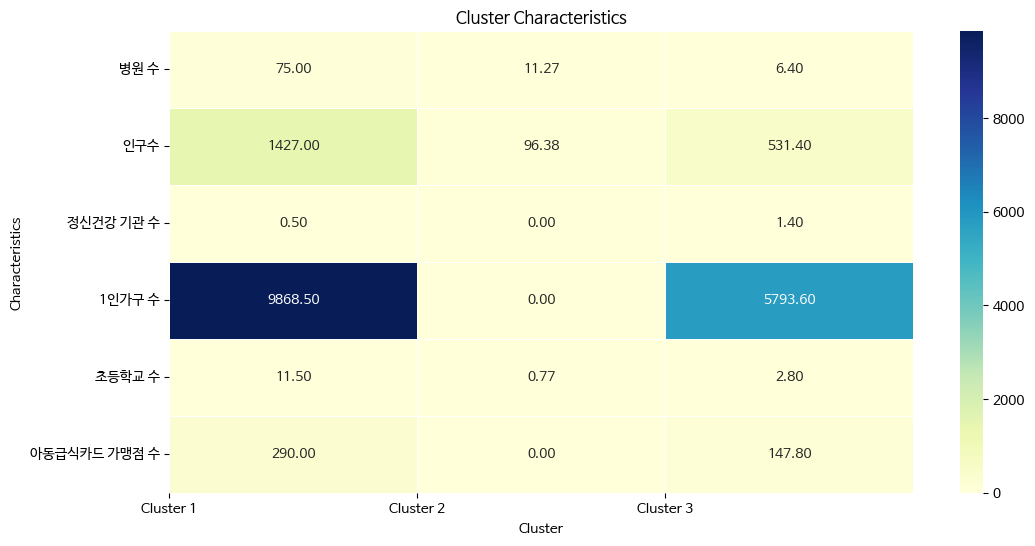

In [28]:
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.T, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title('Cluster Characteristics')
plt.xlabel('Cluster')
plt.ylabel('Characteristics')
plt.xticks(ticks=[0, 1, 2], labels=['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.show()